# Network Creation

In [1]:
!pip install torch ./Gym-Wordle

Defaulting to user installation because normal site-packages is not writeable
Processing ./Gym-Wordle
  Created wheel for gym-wordle: filename=gym_wordle-0.1.3-py3-none-any.whl size=100034 sha256=7aeb1a60361b3af943ac0c3e88fc2283b9b459e6d82fcd307701e21b97d88ad8
  Stored in directory: /user/jbreindl/.cache/pip/wheels/0d/2e/81/517ba7ac1c380991dcfb356e28b3f91d7064d3e7f18cf3c521
Successfully built gym-wordle
  Attempting uninstall: gym-wordle
    Found existing installation: gym-wordle 0.1.3
    Uninstalling gym-wordle-0.1.3:
      Successfully uninstalled gym-wordle-0.1.3


In [2]:
import torch
import matplotlib.pyplot as plt
from torch import normal

In [3]:
from torch import nn

class ActorNetwork(nn.Module):
    """LSTM RNN for generating words for wordle solver"""
    def __init__(self, input_size, output_size=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            #nn.Linear(32, 32),
            #nn.ReLU(),
            nn.Linear(32, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.network(x)
        return y

class CriticNet(nn.Module):
    """Network representing the critic"""
    def __init__(self, in_shape):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
            )

    def forward(self, x):
        return self.network(x)

# Figuring out the environment

In [4]:
import gym
import gym_wordle.utils
import numpy as np
wordle = gym.make('Wordle-v0')

# Use entropy minimization for reward function

In [5]:
def entropy_critic(guess: np.ndarray, remaining_space: np.ndarray):
    # get guess and the values
    orig_space = remaining_space.shape[0]
    split = np.split(guess, 2)
    g = split[0]
    vals = split[1]
    explored = set()

    # get complete matches (i.e. matches based on position)
    matches = np.argwhere(vals==1).flatten()
    for i in matches:
        remaining_space = remaining_space[np.nonzero(remaining_space[:, i] == g[i])] 
        explored.add(g[i])

    # find remaining words that this letter
    exists = np.argwhere(vals==2).flatten()
    for i in exists:
        if g[i] in explored:
            continue
        else:
            explored.add(g[i])
        e = np.full(remaining_space.shape[0], False)
        for j in range(5):
            if i == j or np.isin(j, matches):
                continue
            e = np.logical_or(e, remaining_space[:, j] == g[i])
        remaining_space = remaining_space[e]

    # we know what letters we DON'T have
    dne = np.argwhere(vals==3).flatten()
    for i in dne:
        if g[i] in explored:
            continue
        else:
            explored.add(g[i])
        e = np.full(remaining_space.shape[0], False)
        for j in range(5):
            if np.isin(j, matches):
                continue
            e = np.logical_or(e, remaining_space[:, j] == g[i])
        remaining_space = remaining_space[np.logical_not(e)]

    # do calc
    p = float(remaining_space.shape[0]) / float(orig_space)
    entropy = -np.log2(p)
    return entropy, remaining_space

# A2C solver

In [6]:
class Advantage_ActorCritic():
    def __init__(self, world: gym.Env, policy_net: ActorNetwork, critic,
                 encoder, policy_alpha,  gamma, max_reward):
        # environment info
        self.world = world
        self.encoder = encoder
        self.max_reward = max_reward

        # actor and critic
        self.actor = policy_net
        self.critic = critic
        self.error_buffer = list()
        self.policy_optimizer = torch.optim.Adam(policy_net.network.parameters(),
                                                 lr=policy_alpha, maximize=True)

        # training info
        self.gamma = gamma
        self.episodes = 0
        self.step = 0
        self.guesses = np.zeros(world.action_space.n)
        self.remaining = None

    def train(self, iterations):
        converged = False
        rewards = list()
        recents = torch.zeros(10)
        i = 0
        while not converged:
            r = self.episode()
            rewards.append(r)
            
            if i < 10:
                recents[i] = r

            else:
                recents.roll(-1, 0)
                recents[9] = r
            i += 1
            # convergence check
            if len(rewards) > 10 and recents.mean() >= self.max_reward:
                converged = True
            converged = True if iterations == i else False
        
        plt.plot(rewards)
        plt.show()

    def episode(self, training=True):
        done = False
        state = self.world.reset().copy()
        episode_reward = 0
        self.episodes += 1
        self.step = -1
        self.remaining = gym_wordle.utils.get_words("solution")
        while not done:
            self.step += 1
            # take on policy action
            encoded = self.encoder(state)
            dist = self.actor(encoded.flatten())

            action = normal(dist[0], dist[1])
            #action *= 2000
            action = int(action.clip(0, self.world.action_space.n-1).round().item())
            self.guesses[action] += 1
            state_prime, reward, done, _ = self.world.step(action)

            # fill buffer
            self.error_buffer.append((state, state_prime, reward, dist))

            # prepare for next iteration
            episode_reward += reward
            state = state_prime.copy()
            if training:
                self.__net_update()

        return episode_reward

    # Actor error
    def policy_error(self, prob, error):
        log_probabs_tensor = prob.reshape(-1)
        return (-log_probabs_tensor * error).mean()

    def __net_update(self):
        # calculate error for policy and critic
        self.actor.network.zero_grad()

        state, state_prime, reward, prob = self.error_buffer.pop(0)
        loss1 = self.critic(state[self.step-1], self.remaining)
        loss2, self.remaining = self.critic(state_prime[self.step], self.remaining)
        policy_error = self.policy_error(prob, loss2-1)

        # backprop
        policy_error.backward()
        #nn.utils.clip_grad_norm_(self.actor.parameters(), 1e-2)
        self.policy_optimizer.step()

# Solving the Environment

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
critic = entropy_critic
actor = ActorNetwork(60, 2).to(device)
agent = Advantage_ActorCritic(wordle, actor, critic, 
lambda x: torch.tensor(x.flatten()).to(torch.float32).to(device),
                              1e-6, 0.9, -4)

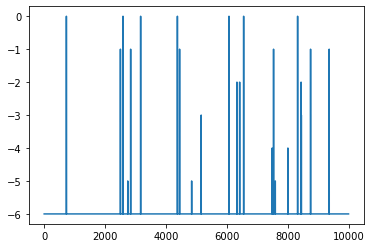

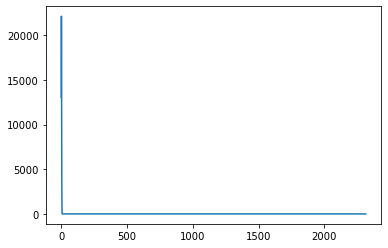

ABACK
ABASE
ABATE
ABBEY
ABBOT
ABHOR


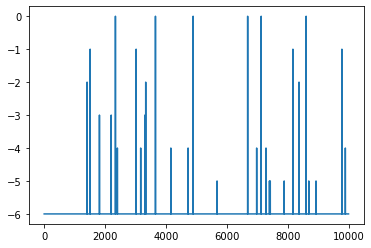

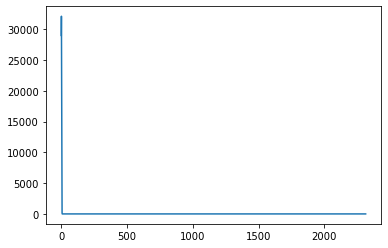

ABACK
ABASE
ABATE
ABBEY
ABBOT
ABIDE


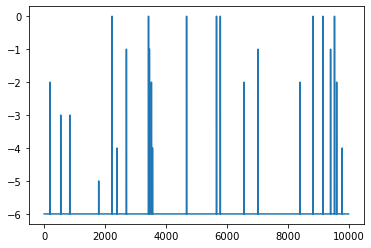

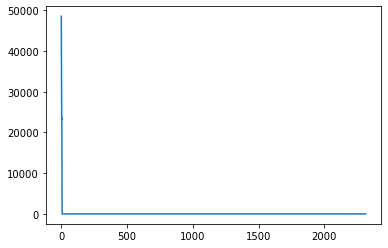

ABACK
ABACK
ABACK
ABASE
ABBEY
ABBEY


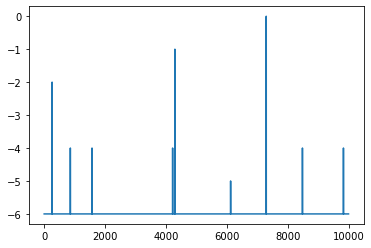

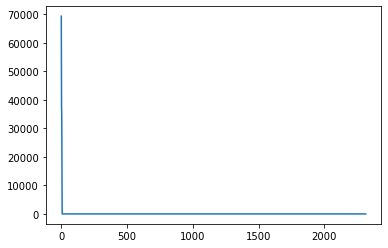

ABACK
ABASE
ABATE
ABBEY
ABBOT
ABIDE


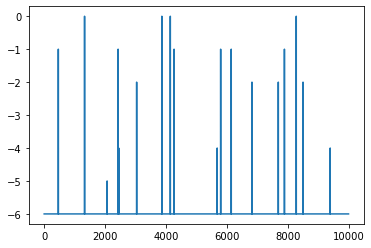

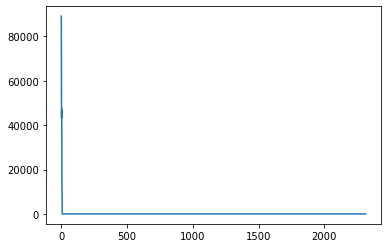

ABACK
ABACK
ABACK
ABASE
ABATE
ABBOT


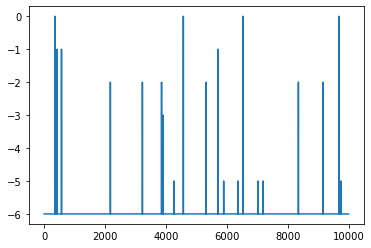

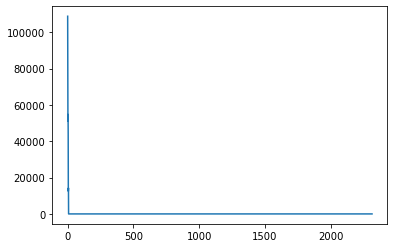

ABACK
ABACK
ABACK
ABACK
ABATE
ABBEY


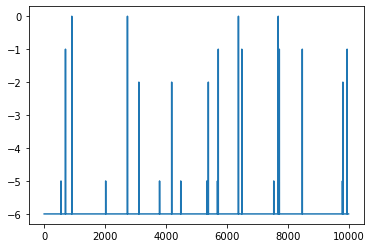

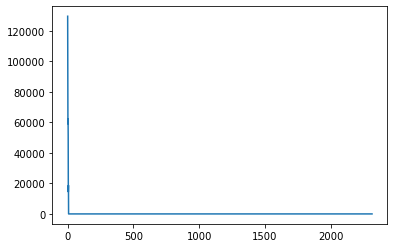

ABACK
ABASE
ABATE
ABBOT
ABHOR
ABIDE


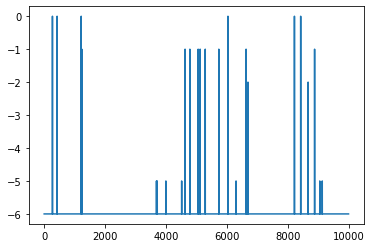

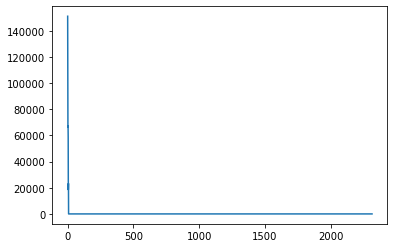

ABACK
ABASE
ABATE
ABBOT
ABHOR
ABIDE


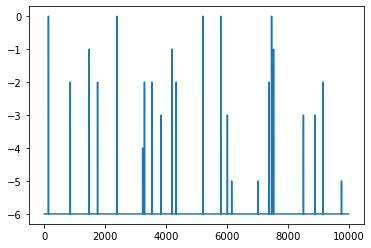

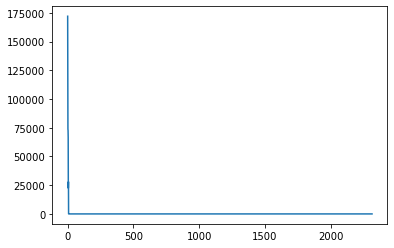

ABACK
ABACK
ABASE
ABATE
ABBEY
ABBOT


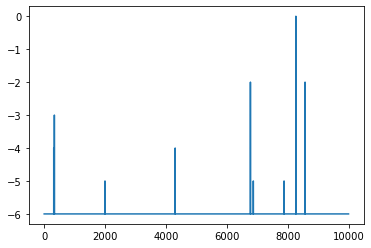

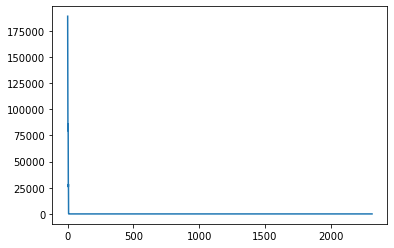

ABACK
ABACK
ABASE
ABATE
ABBOT
ABHOR


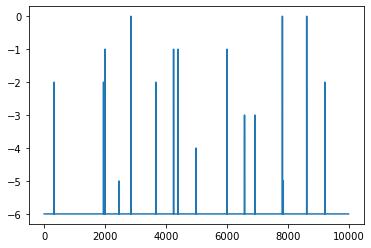

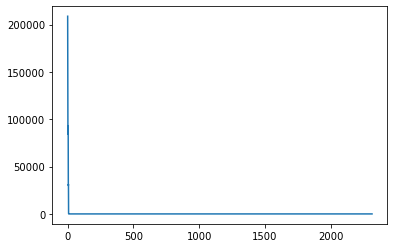

ABACK
ABACK
ABASE
ABATE
ABBOT
ABHOR


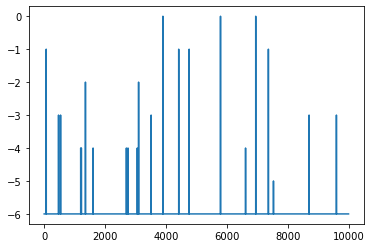

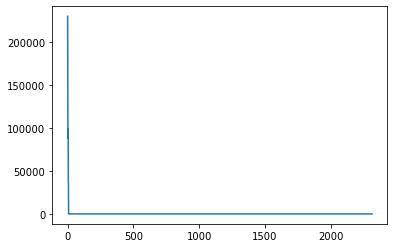

ABACK
ABACK
ABACK
ABASE
ABATE
ABBEY


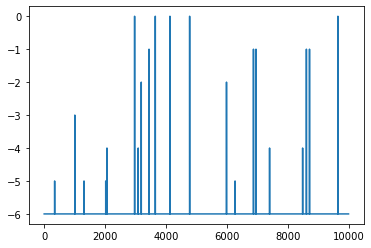

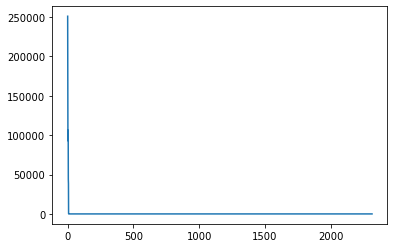

ABACK
ABASE
ABBEY
ABBOT
ABHOR
ABIDE


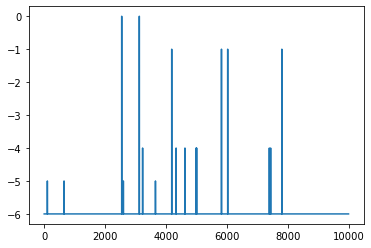

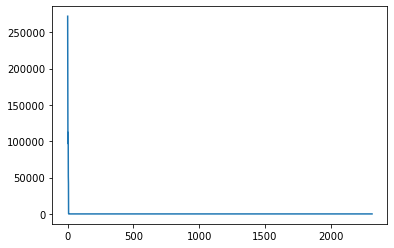

ABACK
ABASE
ABBEY
ABBOT
ABHOR
ABIDE


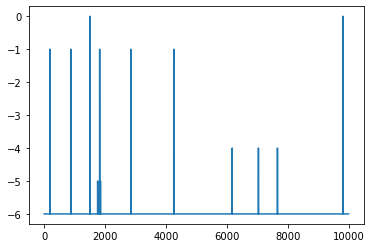

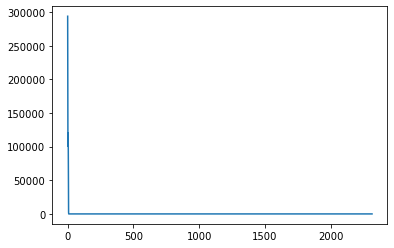

ABACK
ABACK
ABASE
ABATE
ABBOT
ABHOR


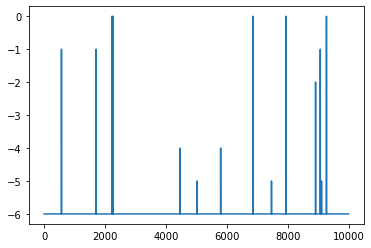

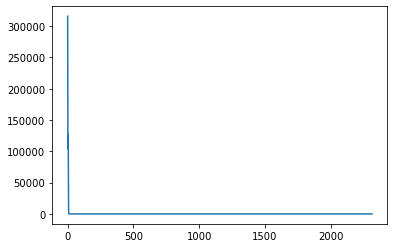

ABACK
ABASE
ABBOT
ABHOR
ABLED
ABORT


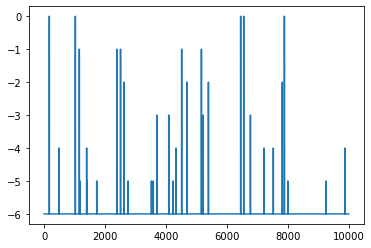

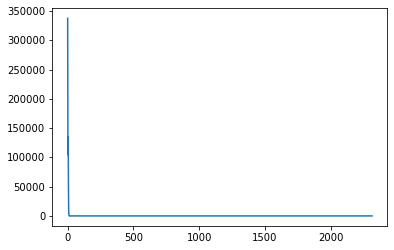

ABACK
ABACK
ABACK
ABASE
ABBEY
ABBOT


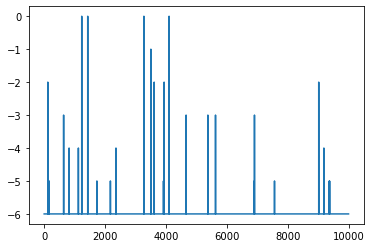

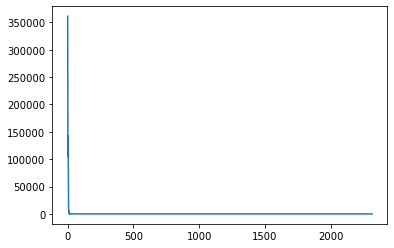

ABACK
ABACK
ABASE
ABBEY
ABBEY
ABBOT


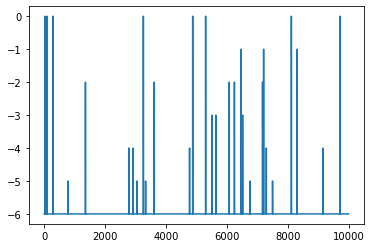

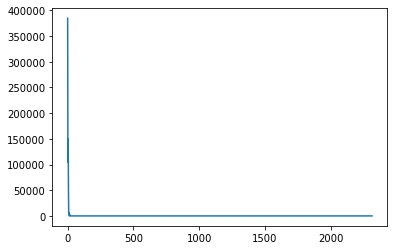

ABACK
ABASE
ABBOT
ABLED
ABOUT
ACTOR


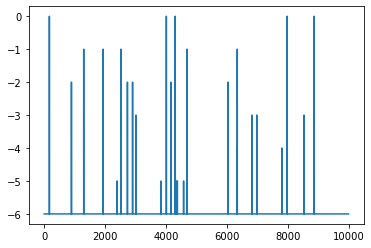

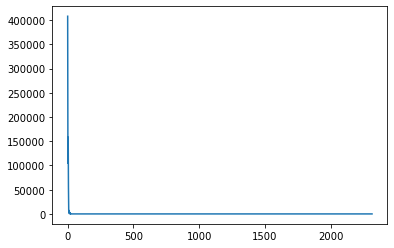

ABACK
ABASE
ABBOT
ABODE
ABYSS
ADMIN


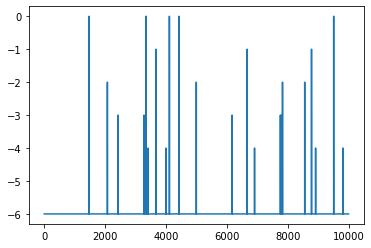

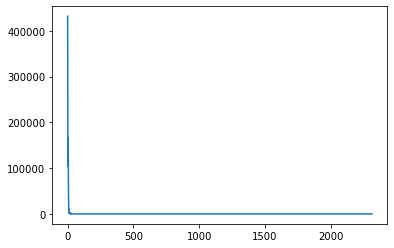

ABACK
ABASE
ABBOT
ABORT
ADAGE
ADAPT


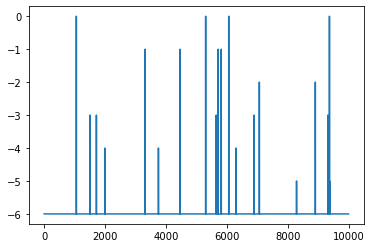

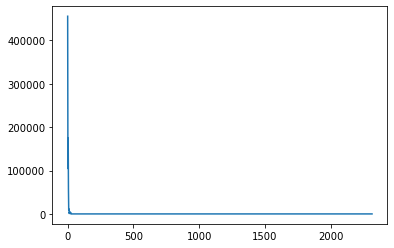

ABACK
ABASE
ABBOT
ABOVE
ADEPT
ADORE


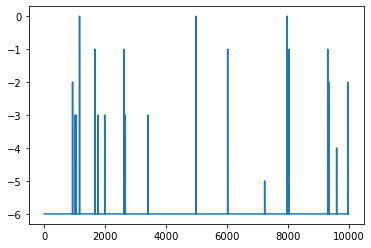

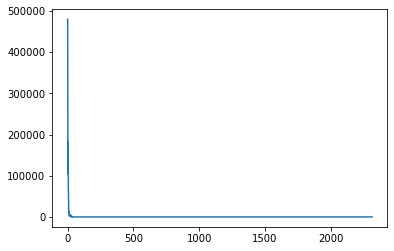

ABACK
ABASE
ABHOR
ACORN
ADOPT
AFTER


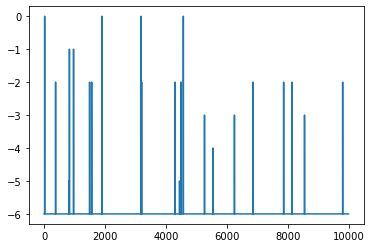

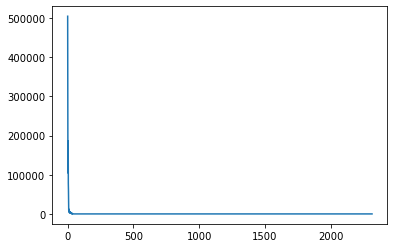

ABACK
ABACK
ABACK
ABACK
ABACK
ABASE


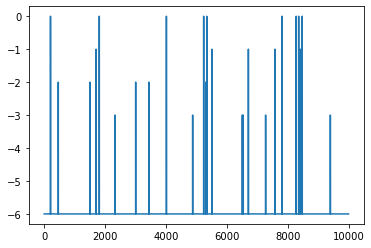

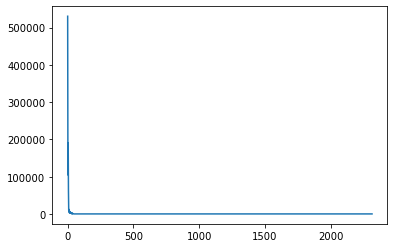

ABACK
ABASE
ABHOR
ACUTE
AGAPE
AGONY


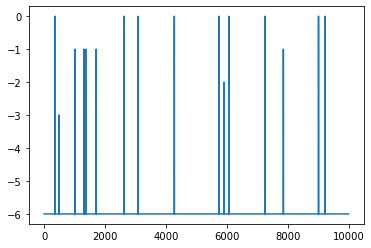

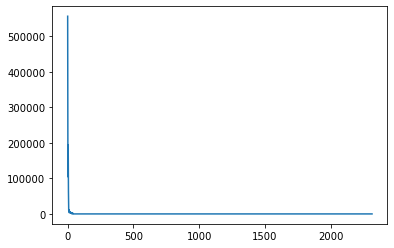

ABACK
ABASE
ABBOT
ACUTE
AGENT
AIDER


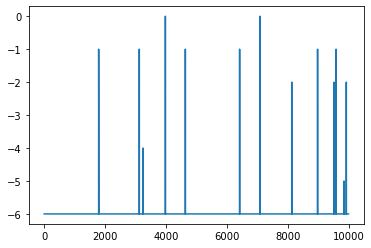

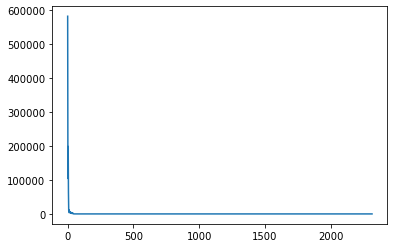

ABACK
ABACK
ABACK
ABACK
ABASE
ABHOR


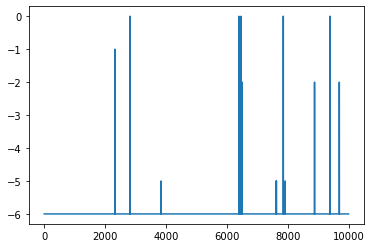

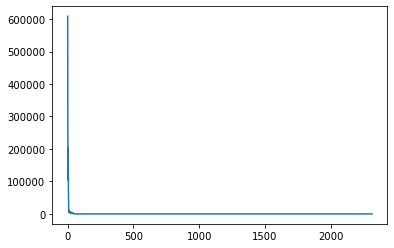

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


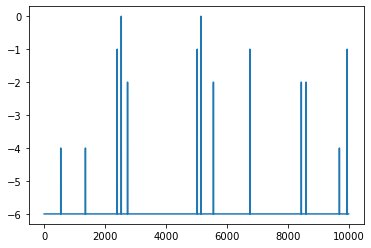

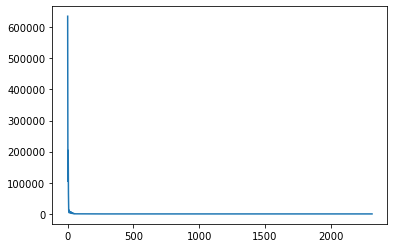

ABACK
ABACK
ABACK
ABASE
ABBOT
ABLED


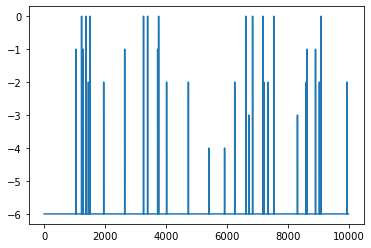

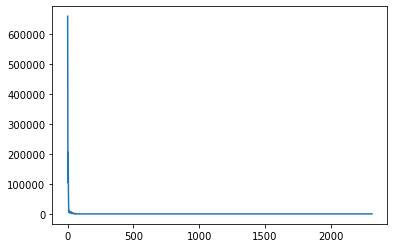

ABACK
ABASE
ABHOR
AFOUL
ALONE
ANIME


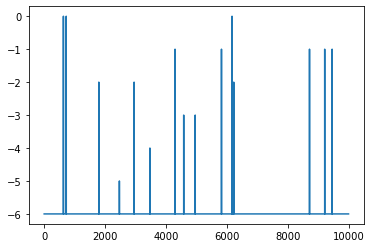

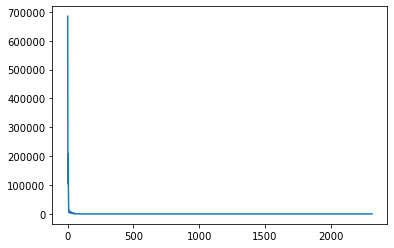

ABACK
ABACK
ABASE
ACORN
AISLE
AMISS


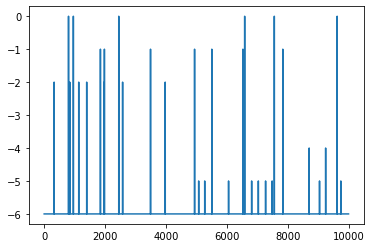

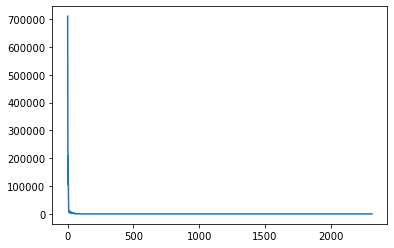

ABACK
ABASE
ABLED
ADORN
ALOOF
APART


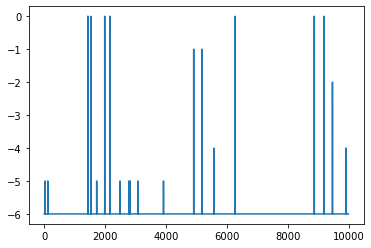

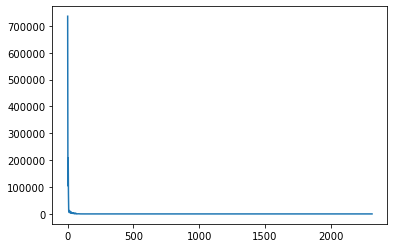

ABACK
ABACK
ABASE
ABYSS
ALTAR
APTLY


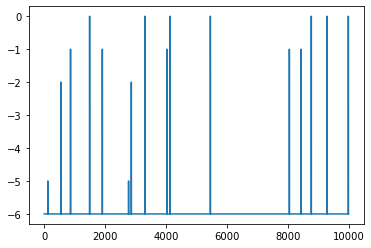

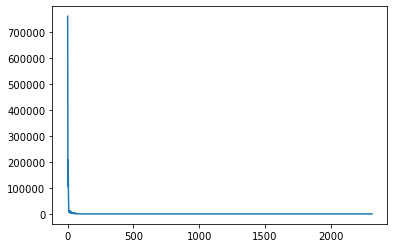

ABACK
ABACK
ABASE
ABOUT
ALIBI
AMITY


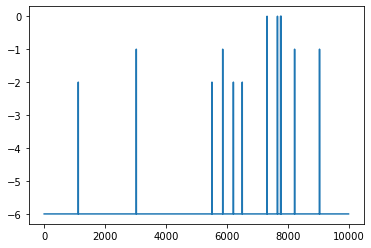

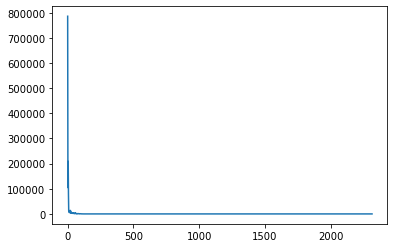

ABACK
ABACK
ABACK
ABACK
ABACK
ABASE


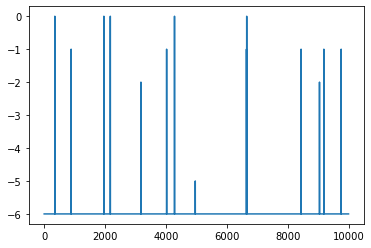

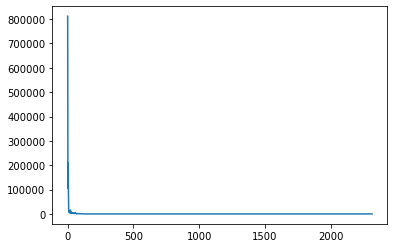

ABACK
ABACK
ABASE
ABOUT
ALIKE
ANTIC


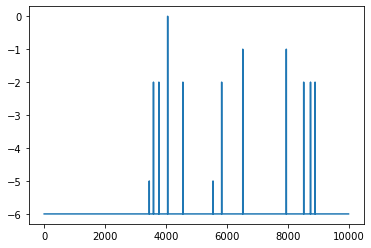

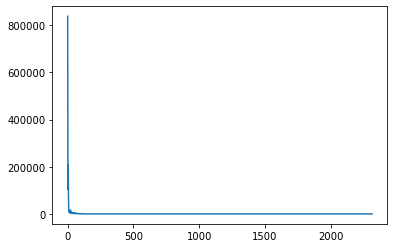

ABACK
ABACK
ABACK
ABACK
ABACK
ABASE


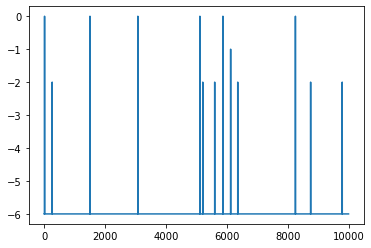

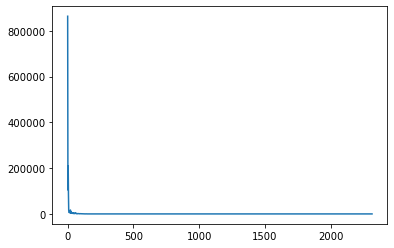

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


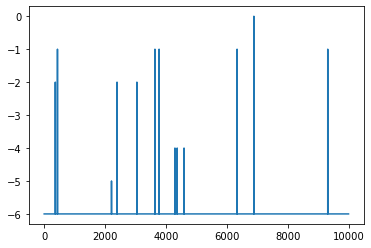

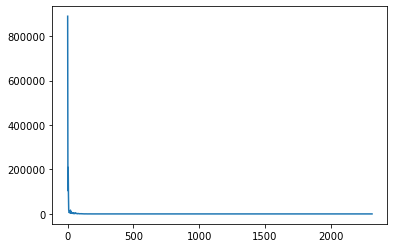

ABACK
ABASE
ABLED
AFIRE
AMBLE
ARRAY


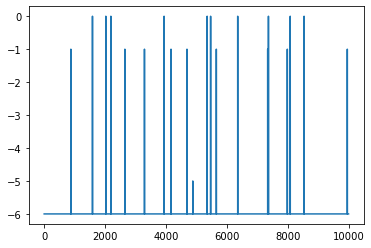

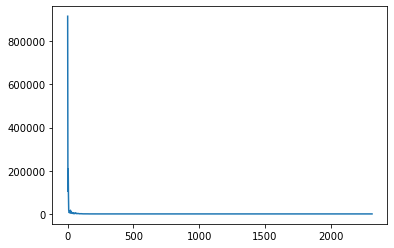

ABACK
ABACK
ABACK
ABACK
ABACK
ABASE


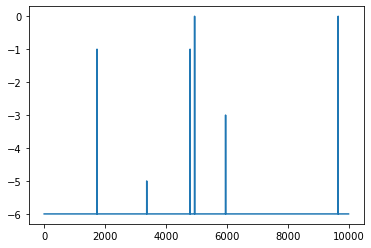

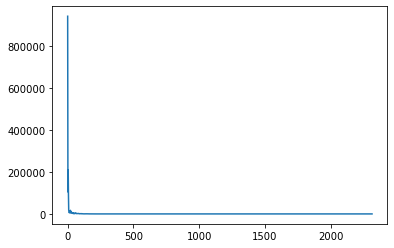

ABACK
ABASE
ABLED
AFFIX
ANNOY
BEGIN


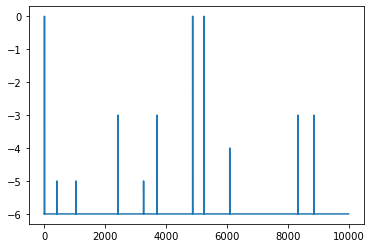

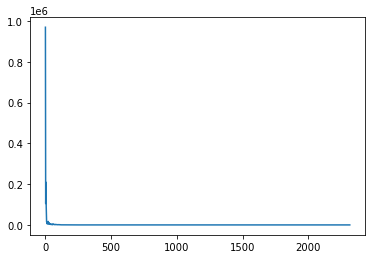

ABACK
ABACK
ABACK
ABACK
ABASE
ACORN


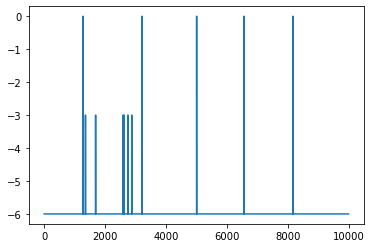

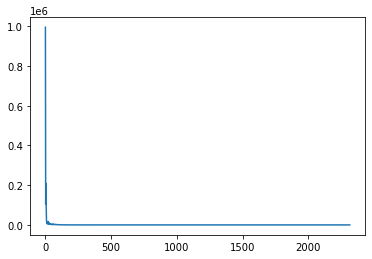

ABACK
ABACK
ABACK
ABACK
ABASE
ABYSS


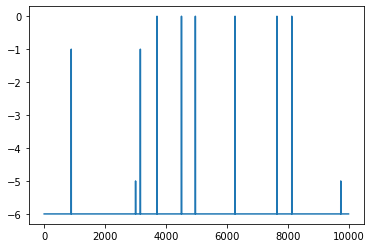

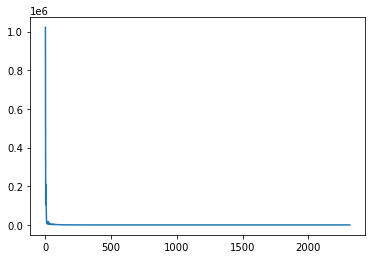

ABACK
ABACK
ABASE
ABHOR
ALGAE
ARMOR


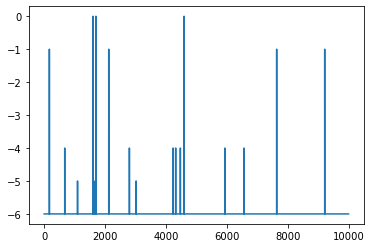

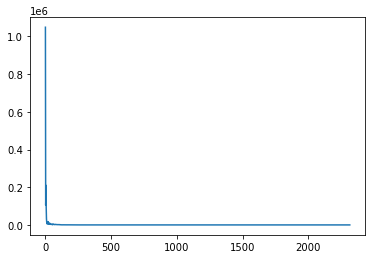

ABACK
ABASE
ABORT
AMISS
BESET
BRUTE


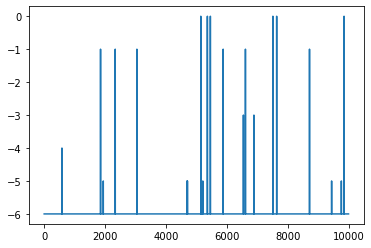

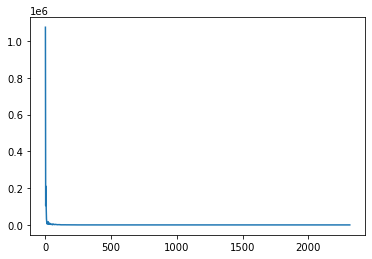

ABACK
ABACK
ABACK
ABACK
ABACK
ABASE


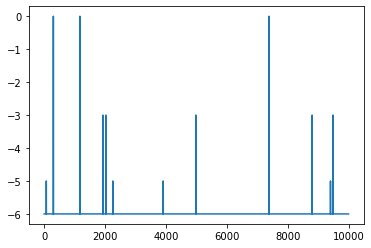

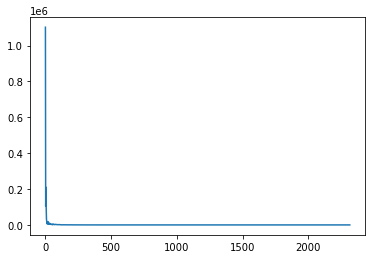

ABACK
ABASE
ABORT
APTLY
BUSHY
CROWD


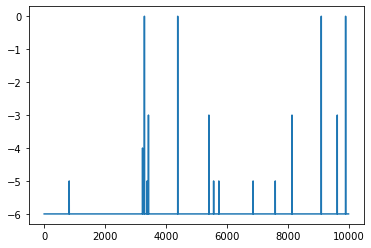

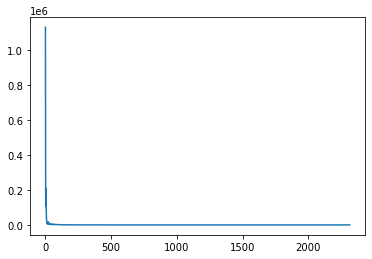

ABACK
ABASE
ABOUT
AUDIT
BREAD
CHEER


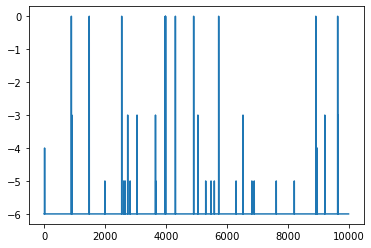

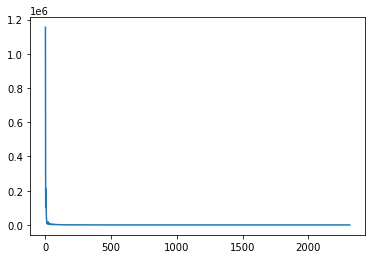

ABACK
ABASE
ABOUT
AWFUL
CACTI
CHOSE


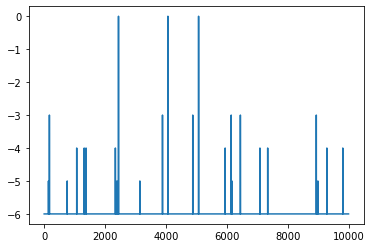

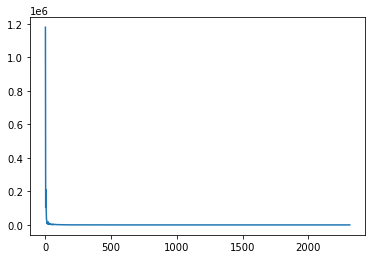

ABACK
ABASE
ABOUT
BALMY
BUXOM
DEVIL


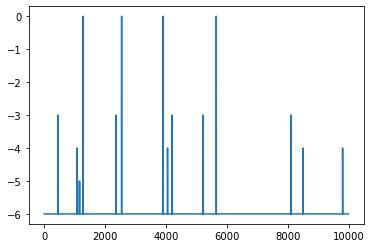

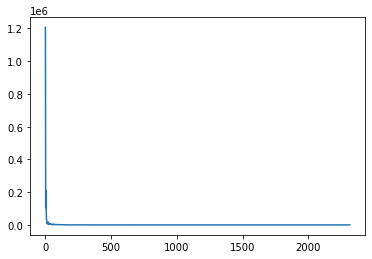

ABACK
ABASE
ABORT
BAKER
BRINK
COUGH


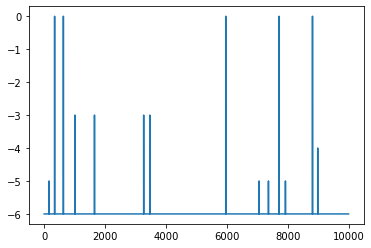

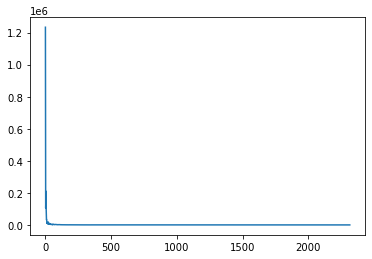

ABACK
ABACK
ABACK
ABATE
ADEPT
APRON


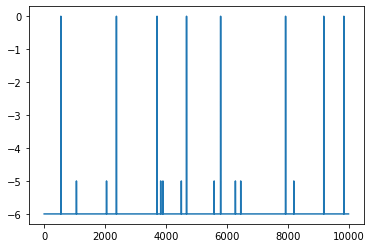

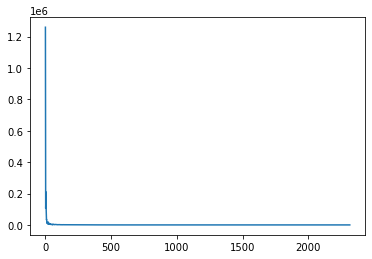

ABACK
ABASE
ACTOR
BILLY
CLOUT
DUNCE


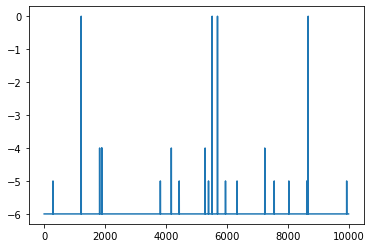

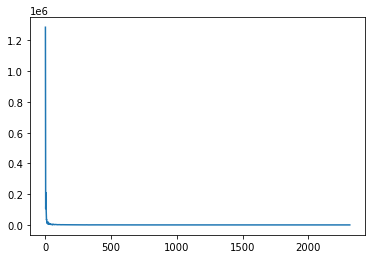

ABACK
ABACK
ABACK
ABASE
ABUSE
BATHE


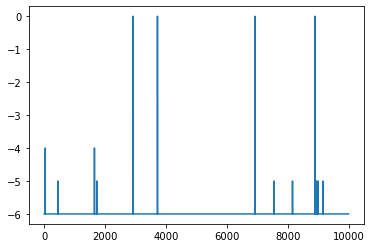

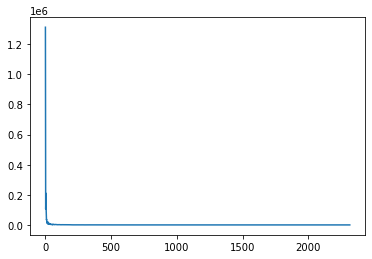

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


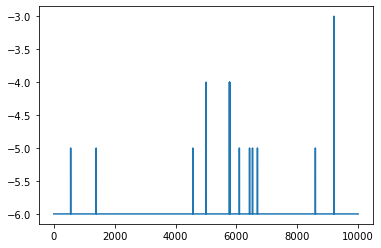

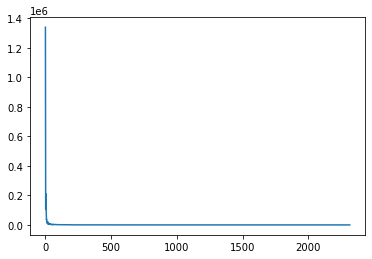

ABACK
ABASE
ABOUT
BLAND
CANON
CREME


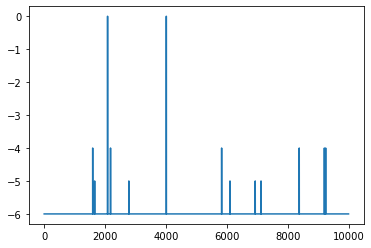

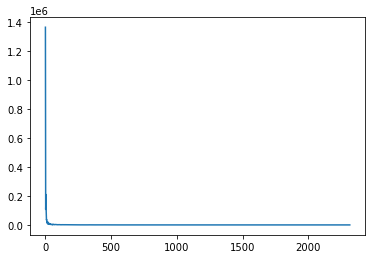

ABACK
ABACK
ABACK
ABACK
ABASE
ABODE


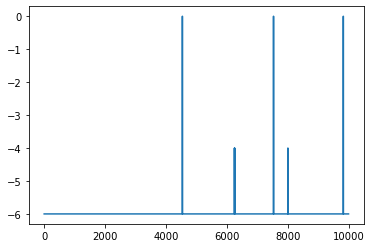

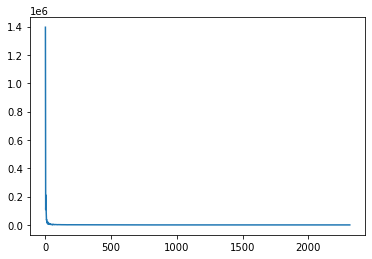

ABACK
ABASE
ABOUT
BLISS
CURVE
FRITZ


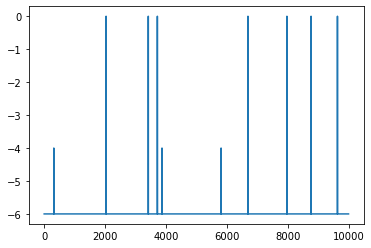

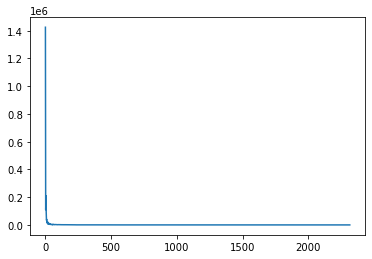

ABACK
ABASE
ABOVE
BLAST
COPSE
FAUNA


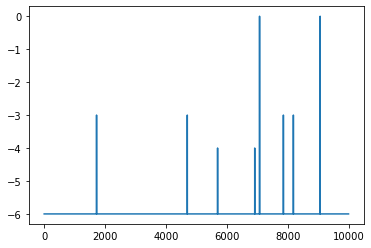

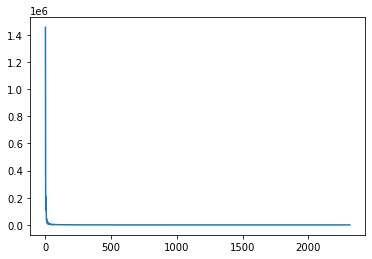

ABACK
ABASE
ABOUT
BOOST
EMBER
FUZZY


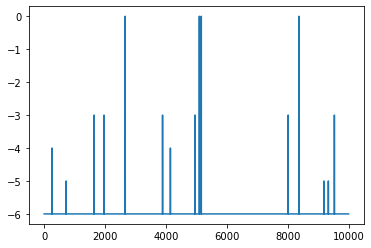

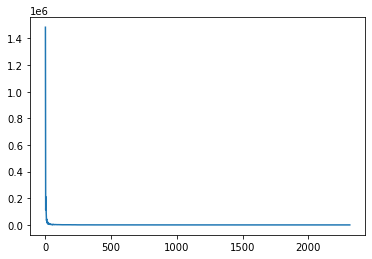

ABACK
ABASE
ABOUT
BOSSY
FILER
HEAVE


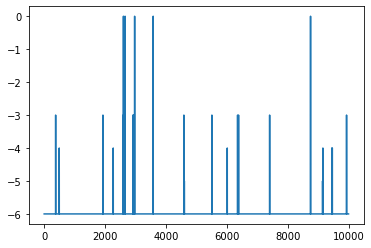

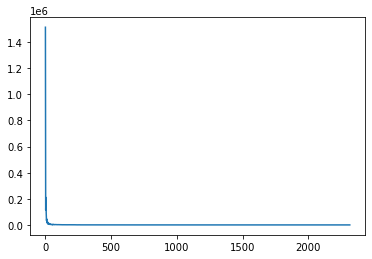

ABACK
ABASE
ABOUT
BRAIN
DAISY
FACET


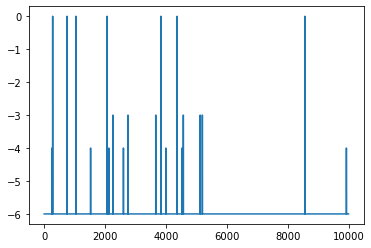

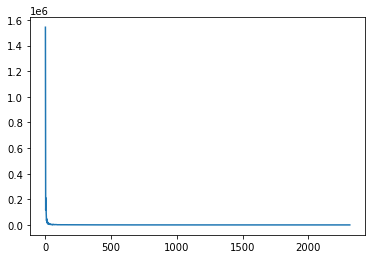

ABACK
ABACK
ABACK
ABACK
ABATE
ADMIN


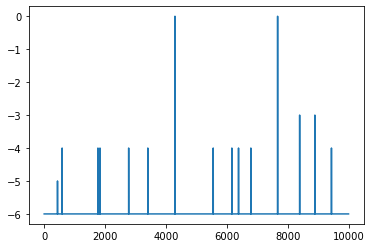

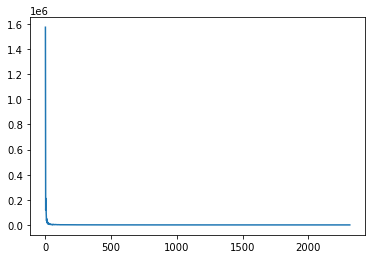

ABACK
ABASE
ADMIN
BLAND
CLOTH
FIRST


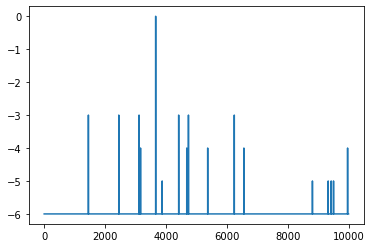

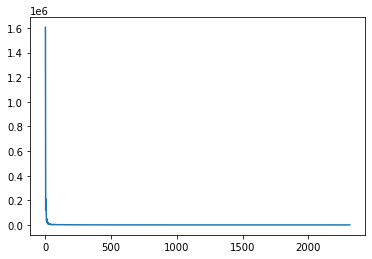

ABACK
ABASE
ABOVE
BRASS
EKING
GRAVE


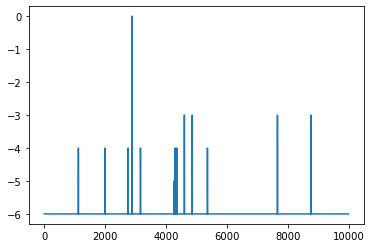

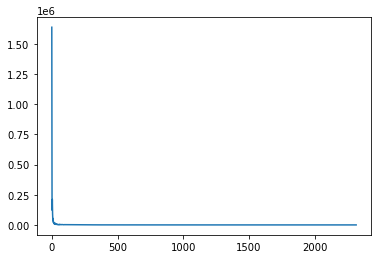

ABACK
ABASE
ABOVE
BRING
EXILE
KRILL


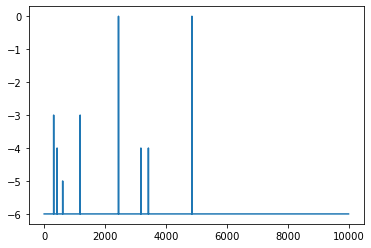

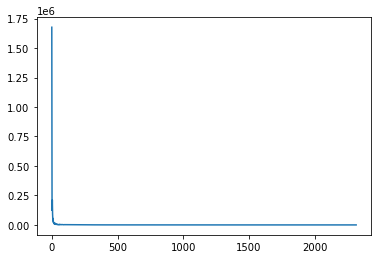

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


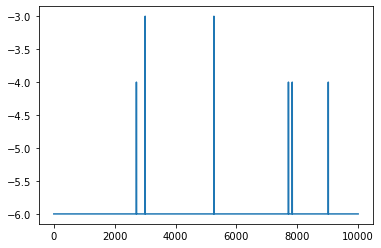

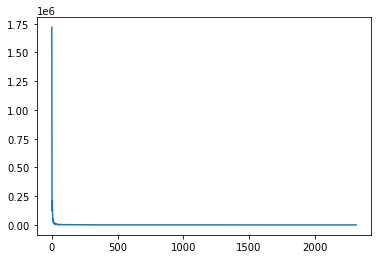

ABACK
ABACK
ABACK
ABACK
ABACK
ABOUT


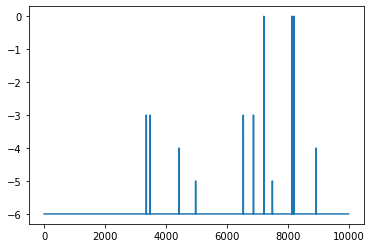

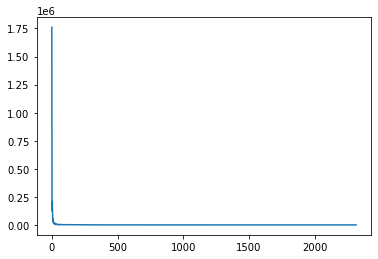

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


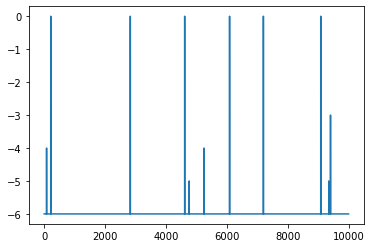

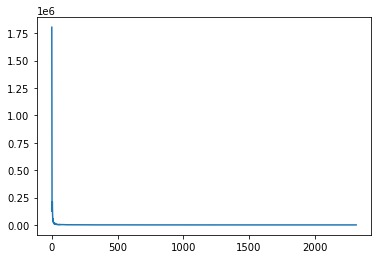

ABACK
ABASE
ABORT
CHARD
EERIE
HUSSY


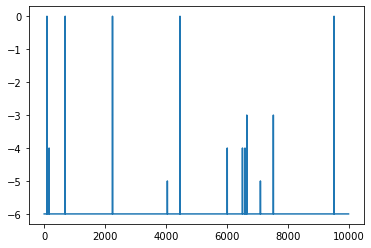

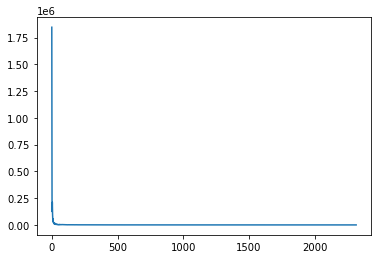

ABACK
ABACK
ABACK
ABACK
ABACK
ADOPT


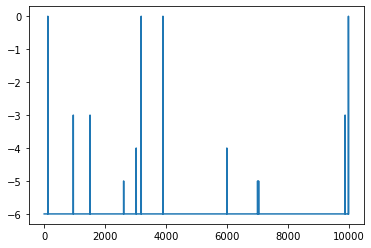

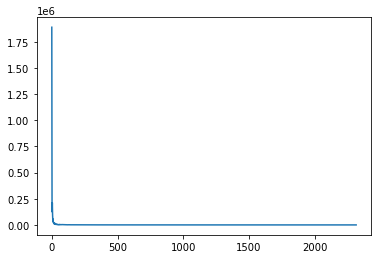

ABACK
ABASE
ABBOT
BEAST
DEALT
EXTRA


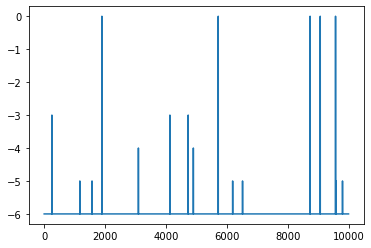

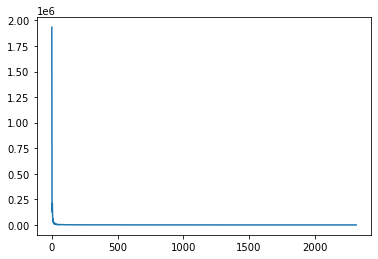

ABACK
ABATE
ACUTE
CREAK
GROAN
PUNCH


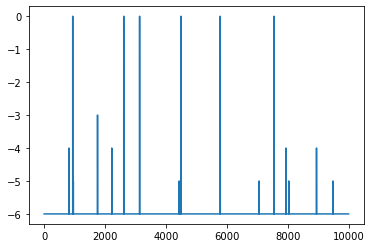

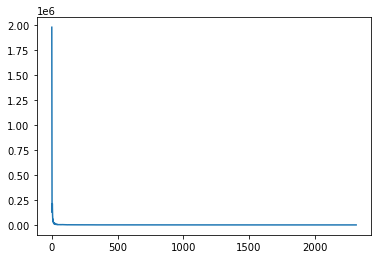

ABACK
ABACK
ABACK
ABACK
ABACK
ABHOR


KeyboardInterrupt: 

In [8]:
for _ in range(100):
    agent.train(10000)
    plt.plot(agent.guesses)
    plt.show()
    agent.world.render()

In [9]:
agent.episode()
agent.world.render()
print(agent.guesses[0])

ABACK
ABACK
ABACK
ABACK
ABACK
ABASE
2004278.0


In [10]:
torch.save(agent.actor.state_dict(), "long_train.pt")